In [1]:
import torch
import torch.utils.data
import torch.cuda
import torch.optim
import torch.nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
def imshow(imgs, label=""):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation="nearest")  # type: ignore
    ax[0][0].axis("off")  # type: ignore
    ax[0][0].set_title(label)  # type: ignore
    fig.show()  # type: ignore


def check_mem():
    return torch.cuda.memory_allocated() / 1024 / 1024 / 1024


In [3]:
from functools import lru_cache

datadir = Path('../../data')
patchesdir = Path('../Patches')
maindir = Path('..')

# imagenet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

sampler = torch.utils.data.RandomSampler

@lru_cache(maxsize=10)
def dataset(img_size, split="train"):
    return datasets.ImageNet(root=str(datadir), split=split, transform=transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
            to_tensor
        ]))

def subset(imageset, size):
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [4]:
from patch_maker import PatchMaker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pm = PatchMaker(mean, std, device=device)
patch_size = 140
batch_size = 10

train_size = 20 * batch_size
test_size  = 10 * batch_size
n_epochs = 30
patch = to_tensor(Image.open('../Patches/toaster.png'))

lr = 1
lr_change = { 0: 1, 10: 0.1, 20: 0.01 }
momentum = 0.9

pm.set_patch(patch, patch_size)
# pm.random_init_patch(patch_size)
pm.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.3))


In [5]:
def cached_random_patch_place(img_tensor):
    b = img_tensor.shape[0]
    rotation = pm.tr_rotate_angle(b)
    shear = pm.tr_shear(b)
    size_by_im = pm.tr_size_by_im(b)

    im_size = torch.tensor(img_tensor.shape[-2:], device=pm.device)

    side_size = min(im_size) * (size_by_im * 2 / np.pi).sqrt()  # type: ignore

    scale = side_size / min(pm._patch_size)
    patch_size = pm._patch_size.unsqueeze(0) * scale.unsqueeze(1)

    location = torch.rand(b, 2, device=pm.device) * (
        im_size - patch_size
    )
    
    xy = (location + patch_size / 2) / im_size
    wh = patch_size / im_size

    return pm.applicate_patch(img_tensor, rotation, scale, shear, location), torch.cat((xy, wh), 1)

In [6]:
dl = dataloader(subset(dataset(416), 10), 5)

In [7]:
xy = (location + patch_size.unsqueeze(0) * scale.unsqueeze(1) / 2) / im_size
wh = patch_size.unsqueeze(0) * scale.unsqueeze(1) / im_size

NameError: name 'location' is not defined

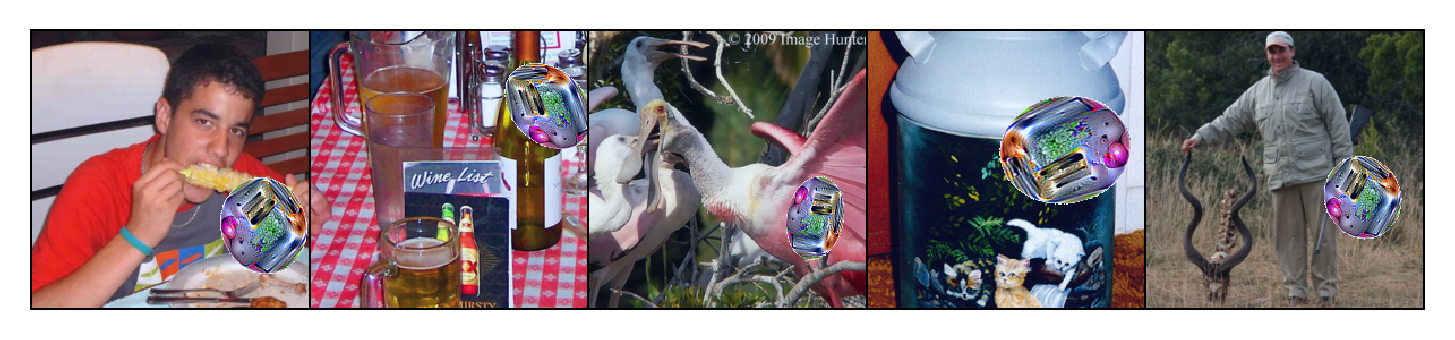

In [84]:
imshow(res[0][0])

In [85]:
res[0][1]

tensor([[0.8258, 0.6917, 0.3309, 0.3309],
        [0.8348, 0.2465, 0.3108, 0.3108],
        [0.7908, 0.6494, 0.2561, 0.2561],
        [0.6908, 0.4052, 0.4339, 0.4339],
        [0.7743, 0.5926, 0.2898, 0.2898]], device='cuda:0')

In [80]:
torch.cat((res[0][1], res[0][2]), 1)

tensor([[0.8309, 0.2451, 0.2771, 0.2771],
        [0.6061, 0.7463, 0.4135, 0.4135],
        [0.2438, 0.7214, 0.3596, 0.3596],
        [0.2740, 0.4630, 0.3405, 0.3405],
        [0.3325, 0.5541, 0.2730, 0.2730]], device='cuda:0')

In [19]:
t = res[0][1:]

In [25]:
t = t[0].cpu().numpy()

In [28]:
t = res[0][1].cpu().numpy()
np.append(t, res[0][2].cpu().numpy())

array([0.77609575, 0.5980452 , 0.27924675, 0.27924675], dtype=float32)

In [14]:
patches_folder = Path.cwd().parent / "Patches" / "train"
patches_folder.iterdir()

<generator object Path.iterdir at 0x000001B573734C10>

In [27]:
folder_size = {
    "train": 1000,
    "val": 200,
    "test": 200
}

In [29]:
import random
from uuid import uuid4

data_folder = Path.cwd() / "data"
patches = [None] + list(patches_folder.iterdir())
for folder, size in folder_size.items():
    parent_folder = data_folder / folder
    images_folder = parent_folder / "images"
    labels_folder = parent_folder / "labels"
    if not Path.exists(images_folder):
        Path.mkdir(images_folder, parents=True)
    if not Path.exists(labels_folder):
        Path.mkdir(labels_folder)
    dl = dataloader(subset(dataset(416), size), batch_size)
    
    for data, _ in dl:
        patch_path = random.choice(patches)
        data = data.to(device)
        if patch_path:
            patch = to_tensor(Image.open(patch_path))
            pm.set_patch(patch, patch_size)
            data, placements = cached_random_patch_place(data)
        for ind, img in enumerate(data):
            name = str(uuid4())
            while Path.exists(images_folder / f"{name}.jpg"):
                name = str(uuid4())

            to_pil(img).save(images_folder / f"{name}.jpg")

            with open(labels_folder / f"{name}.txt", "w", encoding="utf-8") as fp:
                if patch_path:
                    fp.write("0 " + " ".join(str(i.item()) for i in placements[ind]))
        

In [112]:

sub_folder = "train"



In [26]:
random.choice(patches)

WindowsPath('D:/Documents/Repos/NIRS/Patches/train/zebracolor_ep_29.png')

In [114]:
from uuid import uuid4

for data, _ in dl:
    data = data.to(device)
    new_data, placements = cached_random_patch_place(data)
    for ind, img in enumerate(new_data):
        name = str(uuid4())
        while Path.exists(images_folder / f"{name}.jpg"):
            name = str(uuid4())
            
        to_pil(img).save(images_folder / f"{name}.jpg")
        
        with open(labels_folder / f"{name}.txt", "w", encoding="utf-8") as fp:
            fp.write("0 " + " ".join(str(i.item()) for i in placements[ind]))
    
    

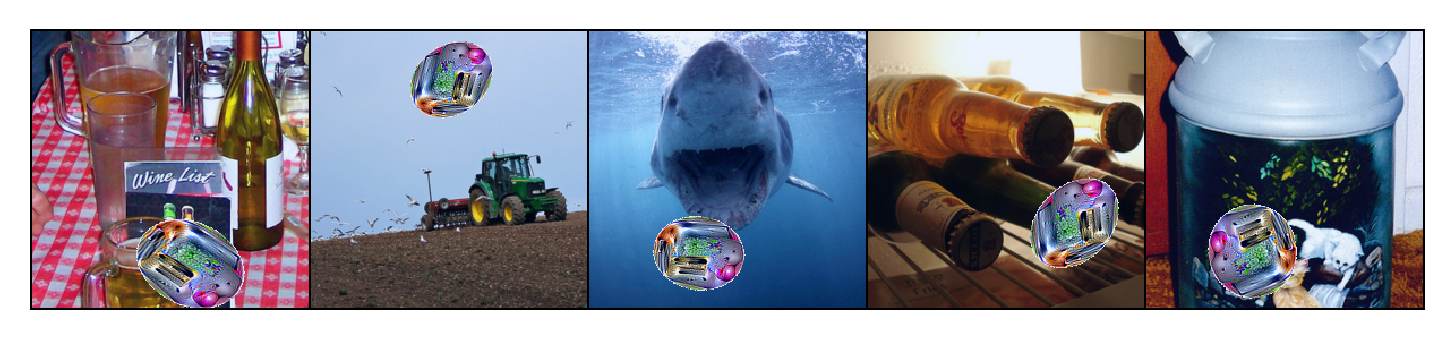

In [89]:
imshow(new_data)

In [109]:
' '.join(str(i.item()) for i in placements[0])

'0.5448228716850281 0.8140755891799927 0.3532469868659973 0.3532469868659973'